In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

/home/okta/miniconda3/envs/data-analysis/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [4]:
# Set Matplotlib
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [6]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

df = pd.read_csv("data/ames.csv")

In [8]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [9]:
# apply pca and extract loadings
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4
GarageArea    0.541229 -0.102375 -0.038470  0.833733
YearRemodAdd  0.427077  0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076 -0.360778 -0.666836 -0.406192
GrLivArea     0.514294 -0.270700  0.742592 -0.332837


## 1) Interpret component loadings
PC1, seems to be a kind of "size" component, similar to what we saw in the tutorial: all of the features have the same sign (positive), indicating that this component is describing a contrast between houses having large values and houses having small values for these features.

The interpretation of the third component PC3 is a little trickier. The features GarageArea and YearRemodAdd both have near-zero loadings, so let's ignore those. This component is mostly about TotalBsmtSF and GrLivArea. It describes a contrast between houses with a lot of living area but small (or non-existant) basements, and the opposite: small houses with large basements.

Our goal here is to use the results of PCA to discover one or more new features that improve the performance of our model. One option is to create features inspired by the loadings. Another option is to use the components themselves as features (that is, add one or more columns of X_pca to X).

## 2) Create New Feature
Based on the loading, I will add new feature to X.

Two possible solutions:
1) inspired by loadings
```python
X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF
```
3) Uses components
`X = X.join(X_pca)`

In [14]:
X = df.copy()
y = X.pop("SalePrice")

X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF

score = score_dataset(X, y)
print(f"Score: {score:.5f} RMSLE")

Score: 0.13792 RMSLE


## 3) Outlier Detection
Outlier can have detrimental effect on the model so it is a good practice to be aware of them and we can use PCA to detect them.

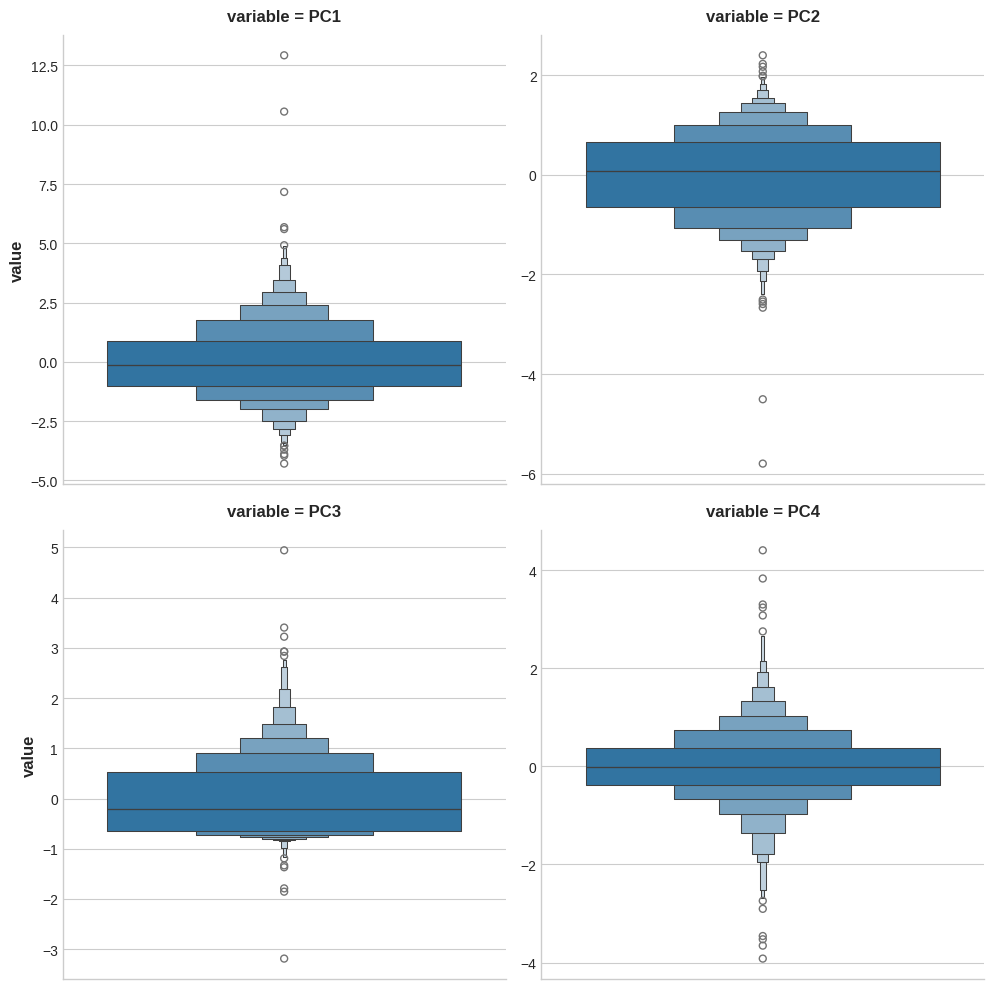

In [18]:
sns.catplot(
    y = "value",
    col = "variable",
    data = X_pca.melt(),
    kind = "boxen",
    sharey = False,
    col_wrap = 2,
);

In each of the components there are several points lying at the extreme ends of the distributions, they are outliers.

In [24]:
# see outlier
comp = "PC1"

idx = X_pca[comp].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0
